# Solución de problemas con árboles de decisión

En este tutorial aprenderás cómo crear un modelo de árboles de decisión mediante una búsqueda exhaustiva de hiperparámetros, graficarás el árbol resultante y, finalmente, evaluarás el mejor modelo usando métricas de rendimiento para un problema de clasificación. Específicamente, verás cómo realizar los siguientes procesos:

1. Importar las librerías requeridas.
2. Cargar un conjunto de datos.
3. Explorar el conjunto de datos.
4. Limpiar y preparar los datos para el modelado.
5. Realizar la búsqueda de hiperparámetros para el modelo de árbol de decisión.
6. Evaluar el mejor modelo resultante.

Utilizaremos el conjunto de datos correspondiente a la compra de seguros de viaje. En este problema queremos predecir si una persona va a comprar un seguro de viaje dependiendo de factores como su edad, salario, educación, entre otros.

## 1. Importación de librerías requeridas

Importaremos las librerías `pandas`, `matplotlib`, `numpy` y `scikit-learn`. En particular, usaremos las siguientes clases y funciones para entrenar y evaluar el modelo de árboles de decisión:

* `DecisionTreeClassifier()`: clase para crear el modelo de árbol de decisión.
* `plot_tree()`: función para obtener una representación gráfica del árbol resultante.
* `classification_report()`: función para obtener un reporte con las métricas de rendimiento por clase.
* `plot_confusion_matrix()`: función para graficar la matriz de confusión.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix

## 2. Carga de datos

Realizaremos la carga de datos usando la función de Pandas `read_csv()`, especificando la ruta y el separador del archivo:

In [2]:
data_raw = pd.read_csv('data/TravelInsurancePrediction.csv', sep=',')

Veamos los primeros datos del conjunto utilizando `head()`:

In [3]:
data_raw.head()

,Index,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


Como puedes observar, nuestro conjunto de datos contiene cuatro variables categóricas: `Employment Type`, `GraduateOrNot`, `FrequentFlyer` y `EverTravelledAbroad`.

## 3. Exploración del conjunto de datos

Primero utilizaremos `data_raw.describe()` para obtener una descripción de las variables numéricas del conjunto de datos. Ten en cuenta que esta función también incluye variables categóricas con clases numéricas como, por ejemplo, la variable `ChronicDiseases` o la variable objetivo `TravelInsurance`. Mediciones como la media o la desviación estándar no tienen mucho sentido en este caso, por lo que no debes tener en cuenta esas columnas:

In [4]:
data_raw.describe()

,Index,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance
count,1987.000000,1987.000000,1.987000e+03,1987.000000,1987.000000,1987.000000
mean,993.000000,29.650226,9.327630e+05,4.752894,0.277806,0.357323
std,573.741812,2.913308,3.768557e+05,1.609650,0.448030,0.479332
min,0.000000,25.000000,3.000000e+05,2.000000,0.000000,0.000000
25%,496.500000,28.000000,6.000000e+05,4.000000,0.000000,0.000000
50%,993.000000,29.000000,9.000000e+05,5.000000,0.000000,0.000000
75%,1489.500000,32.000000,1.250000e+06,6.000000,1.000000,1.000000
max,1986.000000,35.000000,1.800000e+06,9.000000,1.000000,1.000000


En cambio, podemos utilizar `value_counts` para obtener cada valor posible de las variables categóricas y su frecuencia de aparición sobre el total de los datos. Por ejemplo, obtendremos la distribución de valores para la variable `Employment Type`:

In [5]:
pd.value_counts(data_raw['Employment Type'])

Private Sector/Self Employed    1417
Government Sector                570
Name: Employment Type, dtype: int64

Si tienes variables categóricas con los mismos posibles valores (por ejemplo `Yes` y `No`), puedes utilizar la función `apply()` para ejecutar la función `value_counts` sobre todas las columnas simultáneamente (**Nota:** también puedes usar esta función con variables que no tengan los mismos posibles valores. En ese caso, se creará una fila para cada valor único, llenando las celdas con `NaN` en donde no se encuentre el valor):

In [6]:
data_raw[['GraduateOrNot','FrequentFlyer','EverTravelledAbroad']].apply(pd.value_counts)

,GraduateOrNot,FrequentFlyer,EverTravelledAbroad
No,295,1570,1607
Yes,1692,417,380


## 4. Limpieza y preparación de datos

Primero vamos a definir la variable `data` para almacenar un conjunto de datos modificado, utilizando el método `copy()`:

In [7]:
data = data_raw.copy()

### Eliminación de variables poco relevantes

Este conjunto de datos solo tiene una variable poco relevante para predecir si el cliente va a comprar un seguro de viajes: `Index`. Haciendo uso de la función `drop()`, eliminaremos esta variable del DataFrame:

In [8]:
data = data.drop('Index', axis=1)

### Eliminación de nulos y duplicados

Posteriormente, revisaremos si nuestros datos contienen datos nulos usando `isna().sum()`:

In [9]:
data.isna().sum()

Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64

Como no se tienen datos nulos, no tendremos que realizar ninguna modificación para tratarlos. Ahora veremos si hay duplicados utilizando `duplicated().sum()`:

In [10]:
data.duplicated().sum()

738

Como tenemos 738 datos duplicados, usaremos `drop_duplicates()` para eliminarlos:

In [11]:
data = data.drop_duplicates()

Finalmente, veremos las dimensiones del conjunto de datos modificado usando `data.shape`:

In [12]:
data.shape

(1249, 9)

### Transformación de variables categóricas

Teóricamente, el modelo de árboles de decisión no necesita que todas las variables sean numéricas, pues simplemente genera divisiones según un criterio a optimizar, usando la distribución de los valores para cada variable. Sin embargo, la implementación de `sklearn` necesita que todos los valores de las variables sean numéricos, por lo que realizaremos una codificación OneHot mediante la función `get_dummies()`:

In [13]:
data = pd.get_dummies(data)

Veremos el resultado de la codificación usando `data.head()`:

In [14]:
data.head()

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance,Employment Type_Government Sector,Employment Type_Private Sector/Self Employed,GraduateOrNot_No,GraduateOrNot_Yes,FrequentFlyer_No,FrequentFlyer_Yes,EverTravelledAbroad_No,EverTravelledAbroad_Yes
0,31,400000,6,1,0,1,0,0,1,1,0,1,0
1,31,1250000,7,0,0,0,1,0,1,1,0,1,0
2,34,500000,4,1,1,0,1,0,1,1,0,1,0
3,28,700000,3,1,0,0,1,0,1,1,0,1,0
4,28,700000,8,1,0,0,1,0,1,0,1,1,0


### División de datos

Ahora dividiremos el conjunto de datos resultante en un conjunto de entrenamiento y uno de pruebas mediante la función `train_test_split()`. Usaremos el 80% de los datos para el entrenamiento y el 20% restante para las pruebas:

In [15]:
train, test = train_test_split(data, test_size=0.2, random_state=9)
train.head()

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance,Employment Type_Government Sector,Employment Type_Private Sector/Self Employed,GraduateOrNot_No,GraduateOrNot_Yes,FrequentFlyer_No,FrequentFlyer_Yes,EverTravelledAbroad_No,EverTravelledAbroad_Yes
722,33,400000,8,0,1,1,0,0,1,1,0,1,0
1263,28,600000,7,1,0,1,0,0,1,1,0,1,0
1690,35,800000,6,1,1,0,1,1,0,1,0,0,1
263,35,800000,4,0,0,0,1,1,0,1,0,1,0
913,31,1400000,4,0,1,0,1,0,1,1,0,0,1


Además, separaremos la variable objetivo `TravelInsurance` de las variables descriptoras:

In [16]:
x_train = train.drop(['TravelInsurance'],axis=1)
y_train = train['TravelInsurance']

Una de las ventajas de los árboles de decisión es que no necesitan que los datos estén estandarizados, pues los criterios de pureza utilizados para generar las particiones no relacionan estas magnitudes, sino que se calculan por separado para cada variable. Por lo tanto, podemos seguir directamente a la búsqueda de hiperparámetros.

## 5. Búsqueda de hiperparámetros

Primero crearemos un objeto de la clase `DecisionTreeClassifier()`, que será nuestro modelo base para realizar la búsqueda exhaustiva de hiperparámetros. Adicionaremos el parámetro `random_state=0` debido a que, después de definir una división, se reorganizan las variables restantes antes de definir la siguiente división. Esto nos permite tener un comportamiento determinístico durante el entrenamiento:

In [17]:
decision_tree = DecisionTreeClassifier(random_state=0)

Utilizaremos los siguientes parámetros para realizar la búsqueda:
* `criterion`: el criterio de pureza, que determina la calidad de una división. Utilizaremos dos de los más populares: la entropía y GINI.
* `max_depth`: la profundidad máxima del árbol. Este hiperparámetro se utiliza para el control de la complejidad del modelo.
* `min_samples_split`: número mínimo de datos necesarios en un nodo para poder definir una división.

In [18]:
param_grid = {'criterion': ['entropy', 'gini'],
              'max_depth': [2, 4, 6, 8],
              'min_samples_split': [2, 3, 5, 10]}

Además, definiremos un objeto de la clase `KFold()` para realizar la validación cruzada, especificando 10 subconjuntos con el parámetro `n_splits` y reordenando el conjunto de datos en cada iteración con el parámetro `shuffle`:

In [19]:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

Finalmente, definiremos la búsqueda con un objeto de la clase `GridSearchCV()` usando el modelo `decision_tree`, el espacio de búsqueda `param_grid` y la técnica de validación cruzada `kfold`:

In [20]:
grid = GridSearchCV(decision_tree, param_grid, cv=kfold, n_jobs=-1)

Ejecutaremos la búsqueda sobre el conjunto de entrenamiento definido por las variables `x_train` y `y_train`:

In [21]:
grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
          

Ahora obtendremos los mejores valores de los hiperparámetros usando `grid.best_params_`:

In [22]:
print("Mejores parámetros: {}".format(grid.best_params_))

Mejores parámetros: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}


Como puedes ver, el mejor modelo utiliza la entropía como criterio de pureza, una profundidad máxima de 4 y un mínimo de 2 datos para realizar una división. Almacenaremos el mejor modelo utilizando `grid.best_estimator_`:

In [23]:
mejor_modelo = grid.best_estimator_

Podemos utilizar el atributo `feature_importances_` para obtener un arreglo con los pesos asignados a cada variable. Entre más grande sea el peso, más importante es la variable asociada:

In [24]:
importancia = mejor_modelo.feature_importances_
importancia

array([0.12518591, 0.61535117, 0.23262156, 0.        , 0.        ,
       0.        , 0.02684136, 0.        , 0.        , 0.        ,
       0.        , 0.        ])

Utilizando los nombres de las variables almacenados en `x_train.columns`, podemos ver más claramente qué peso corresponde a qué variable. Primero crearemos un DataFrame con los valores almacenados en la variable `importancia` y, posteriormente, lo ordenaremos:

In [25]:
importancia_df = pd.DataFrame(data={'Variable':x_train.columns, 'Importancia':importancia})
importancia_df.sort_values('Importancia', ascending=False)

,Variable,Importancia
1,AnnualIncome,0.615351
2,FamilyMembers,0.232622
0,Age,0.125186
6,GraduateOrNot_No,0.026841
3,ChronicDiseases,0.000000
4,Employment Type_Government Sector,0.000000
5,Employment Type_Private Sector/Self Employed,0.000000
7,GraduateOrNot_Yes,0.000000
8,FrequentFlyer_No,0.000000
9,FrequentFlyer_Yes,0.000000


Como puedes ver, la variable más importante es `AnnualIncome`. Además, las variables relacionadas con enfermedades crónicas, tipo de empleo y viajes no son importantes. 

Ahora utilizaremos `plot_tree` para visualizar el árbol que almacenamos en la variable `mejor_modelo`. Especificaremos el nombre de las variables con el parámetro `feature_names`, el nombre de las clases (en orden ascendente, es decir, primero la clase 0 y luego la clase 1) con el parámetro `class_names` y, finalmente, aplicaremos colores a los nodos para indicar cada clase con el parámetro `filled`:

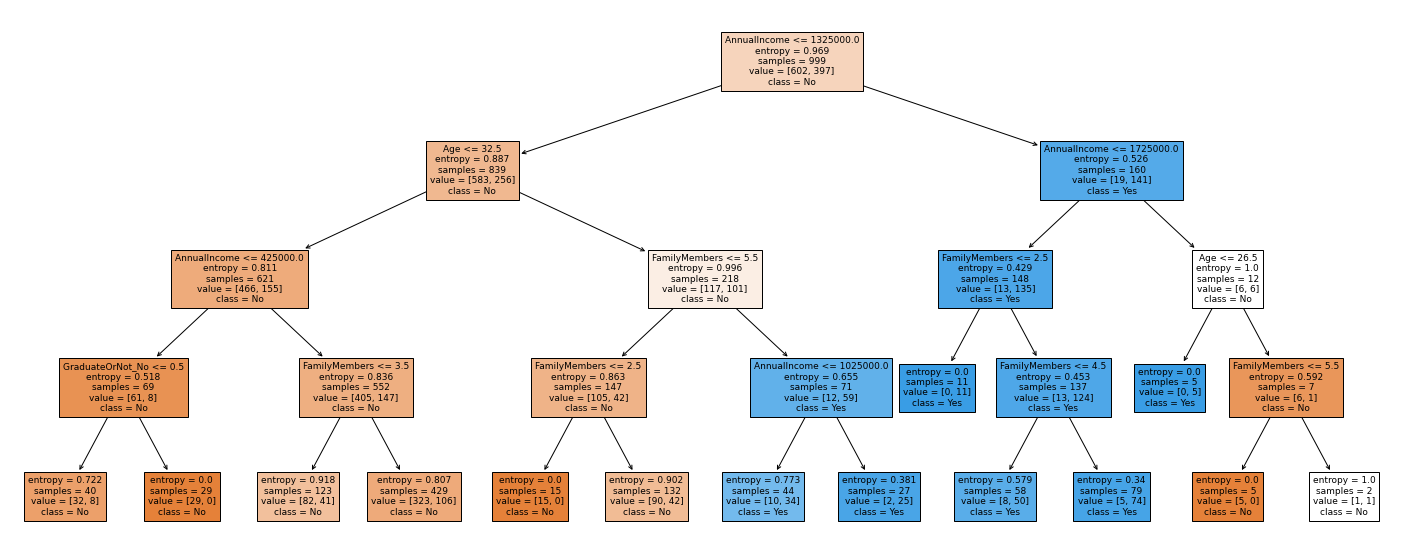

In [26]:
plt.figure(figsize=(25,10))
tree = plot_tree(mejor_modelo, feature_names=x_train.columns, class_names=['No','Yes'], filled=True, fontsize=9)

## 6. Evaluación del mejor modelo

Empezaremos separando la variable objetivo de las variables descriptoras en el conjunto de pruebas:

In [27]:
x_test = test.drop(['TravelInsurance'],axis=1)
y_test = test['TravelInsurance']

A continuación realizaremos predicciones sobre el conjunto de pruebas para comparar con los valores de `y_test`. Utilizaremos la función `predict()` sobre el mejor modelo:

In [28]:
y_pred = mejor_modelo.predict(x_test)

Ahora utilizaremos la función `plot_confusion_matrix()` para generar un mapa de calor con los valores de la matriz de confusión:

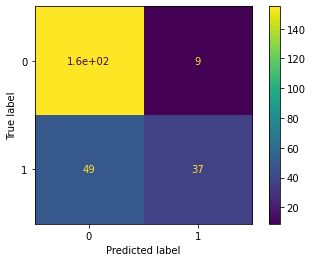

In [29]:
plot_confusion_matrix(mejor_modelo, x_test, y_test)  
plt.show()

Como puedes observar, el modelo tiende a predecir correctamente la clase 0, es decir, tiene mejor desempeño al predecir a las personas que no van a comprar un seguro de viaje. De hecho, para la clase 1, el modelo tiende a predecir erróneamente. Específicamente, podemos observar las métricas de desempeño usando `classification_report()`:

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.95      0.84       164
           1       0.80      0.43      0.56        86

    accuracy                           0.77       250
   macro avg       0.78      0.69      0.70       250
weighted avg       0.78      0.77      0.75       250



De manera similar al modelo de regresión logística, en este modelo se tienen valores altos en la sensibilidad y precisión de la clase 0. Como la clase 1 no tiene tanta representación, se tiene una sensibilidad bastante baja, aunque la precisión tiene un valor alto. Este valor de precisión indica que de los datos que el árbol clasifica en la clase 1 la mayoría realmente pertenecen a esta clase.

### Ejemplo de clasificación con el mejor modelo

Ahora veremos cómo se realiza una clasificación sobre un único dato. Empezaremos definiendo la variable `x_clasif` con uno de los valores del conjunto de test. Ten en cuenta que realizaremos nuestra predicción partiendo de la variable `x_test`, por lo que nuestro dato tiene los cambios resultantes de aplicar la codificación OneHot:

In [31]:
x_clasif = x_test.iloc[1]
x_clasif

Age                                                  28
AnnualIncome                                    1100000
FamilyMembers                                         4
ChronicDiseases                                       1
Employment Type_Government Sector                     0
Employment Type_Private Sector/Self Employed          1
GraduateOrNot_No                                      0
GraduateOrNot_Yes                                     1
FrequentFlyer_No                                      1
FrequentFlyer_Yes                                     0
EverTravelledAbroad_No                                1
EverTravelledAbroad_Yes                               0
Name: 261, dtype: int64

El árbol de decisión también permite utilizar la función `predict_proba()` para realizar la clasificación. Esta función necesita un arreglo de datos, por lo que pasaremos como parámetro un arreglo con una única posición: el dato almacenado en `x_clasif`:

In [32]:
y_clasif = mejor_modelo.predict_proba([x_clasif])
y_clasif

array([[0.75291375, 0.24708625]])

Como puedes observar, el resultado de la predicción es un arreglo de predicciones, que en este caso solo tiene un elemento. El arreglo interno contiene dos posiciones, que representan las dos clases del problema y contienen las probabilidades de pertenencia del dato a cada una de ellas. En el caso del árbol de decisión, estas probabilidades corresponden a la proporción de datos de esta clase en la hoja. Por ejemplo, si realizas la clasificación manualmente, verás que nuestro dato termina en una hoja con 429 muestras, de las cuales 323 corresponden a la clase 0, lo que resulta en un 75.29% de muestras que pertenecen a la clase 0 en esa hoja.

Si queremos obtener la clasificación de nuestro modelo, en vez de las estimaciones de probabilidad, podemos utilizar la función `argmax()` de `numpy`, que retorna el índice del arreglo con mayor valor. En ese sentido, estamos asignando la clase con mayor probabilidad a `x_clasif`:

In [33]:
np.argmax(y_clasif[0])

0

## Cierre

En este tutorial hemos utilizado una nueva clase de scikit-learn para entrenar y evaluar un modelo de clasificación usando árboles de decisión. Específicamente, realizamos una búsqueda exhaustiva de los hiperparámetros de este modelo y graficamos el árbol resultante. Finalmente, evaluamos el rendimiento de nuestro modelo y observamos cómo se realiza una clasificación.

---
Si quieres más información sobre árboles de decisión en `scikit_learn` puedes consultar el [sitio web oficial](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

Para la búsqueda de hiperparámetros con la clase `GridSearchCV()` puedes consultar [este enlace](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

Finalmente, para obtener más información sobre la función `plot_tree` para graficar el árbol, puedes consultar el [sitio web oficial](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html)
